===========================================================================
RELATÓRIO TÉCNICO: NOTEBOOK 02 - MODELO DE LEAD SCORING INSIGHTOS
===========================================================================
Autora: Jessica Rocha
Data: 01 de setembro de 2025
---
## Resumo do Processo de Modelagem
Este relatório documenta o fluxo de trabalho completo executado no notebook 02_lead_scoring_model.ipynb, que transforma os dados brutos da InsightOS num artefato de machine learning treinado e pronto para avaliação. O processo seguiu uma metodologia rigorosa, onde cada etapa foi informada pelas descobertas da fase anterior, garantindo a construção de um modelo robusto e alinhado com as melhores práticas da indústria.
### 1. Preparação do Ambiente e Ingestão de Dados
O trabalho iniciou-se com a configuração de um ambiente de análise seguro e a extração dos dados brutos. Através de uma conexão segura com o banco de dados da InsightOS, utilizando credenciais geridas por dotenv, as tabelas users e user_events foram carregadas como DataFrames do pandas. Uma inspeção inicial validou a integridade e o formato dos dados, garantindo um ponto de partida fiável para a análise.
### 2. Engenharia de Atributos e Análise Exploratória (EDA)
A etapa seguinte foi a mais crucial: a transformação dos dados. Os dados de eventos, de natureza cronológica, foram agregados e consolidados com os dados de utilizadores para criar uma única feature_table. Nesta tabela analítica, cada linha representa um único lead e cada coluna uma característica descritiva do seu comportamento.
A Análise Exploratória desta tabela revelou três insights fundamentais que guiaram todo o resto do projeto:
1. Desequilíbrio de Classes: Foi confirmado que apenas 10.1% dos leads convertem, um desequilíbrio significativo que exige tratamento específico na modelagem.
2. Impacto Preditivo: A campanha de marketing google_gestao_agil demonstrou ter uma correlação visivelmente positiva com a conversão, identificando-a como uma feature de alto valor.
3. Multicolinearidade: O teste de Fator de Inflação da Variância (VIF) detetou uma forte redundância entre os eventos de trial_signup e user_verified, levando à decisão estratégica de remover uma destas variáveis no modelo final para garantir a sua estabilidade.
### 3. Pré-processamento e Pipeline de Treinamento
Com base nas descobertas da EDA, foi construído um pipeline de pré-processamento e modelagem automatizado.
* Baseline e Divisão: Foi estabelecido um modelo DummyClassifier como ponto de referência de performance. Os dados foram então divididos em conjuntos de treino e teste de forma estratificada, uma ação direta para garantir que o desequilíbrio de classes fosse representado corretamente em ambas as amostras.
* Pipeline de Transformação: Utilizando o ColumnTransformer do Scikit-learn, foi criado um preprocessor para aplicar StandardScaler às features numéricas e OneHotEncoder às categóricas.
* Treinamento do Modelo: Este pré-processador foi integrado num Pipeline final juntamente com um classificador LogisticRegression. O modelo foi configurado com o parâmetro class_weight='balanced', uma segunda medida técnica para mitigar o efeito do desequilíbrio de classes. O pipeline completo foi então treinado utilizando apenas os dados de treino.
### 4. Conclusão e Persistência do Artefato
O processo culminou com a persistência do pipeline treinado num ficheiro lead_scoring_pipeline_v1.joblib. O resultado é um artefato de machine learning completo e autocontido, que encapsula toda a lógica de pré-processamento e o modelo preditivo. Este sistema está agora pronto para a fase final: a avaliação de performance em dados nunca vistos.

In [1]:
# --- CÉLULA 1: IMPORTAÇÕES E CONFIGURAÇÃO DA CONEXÃO ---

# Começo por importar todas as bibliotecas que vou precisar nesta análise.
import os
import pandas as pd  # A minha ferramenta principal para manipulação de dados.
import numpy as np   # Para operações numéricas.
from supabase import create_client, Client # Para me conectar à API do Supabase.
from dotenv import load_dotenv, find_dotenv # Para carregar as minhas credenciais de forma segura.
import seaborn as sns # Para criar visualizações estatísticas mais apelativas.
import matplotlib.pyplot as plt # A base para a maioria das visualizações em Python.
from statsmodels.stats.outliers_influence import variance_inflation_factor # Uma ferramenta específica para detetar multicolinearidade.
import json # Preciso desta biblioteca para conseguir ler os dados JSON que guardei no banco.

# Uma pequena configuração do pandas para garantir que consigo ver todas as colunas quando imprimir um DataFrame.
pd.set_option('display.max_columns', None)

print("CÉLULA 1: Bibliotecas importadas com sucesso.")

# Agora, estabeleço a conexão com o meu banco de dados no Supabase.
try:
    # CORREÇÃO: Uso find_dotenv() para garantir que o ficheiro .env seja encontrado,
    # mesmo que o notebook esteja a ser executado de uma subpasta.
    load_dotenv(find_dotenv()) 
    url: str = os.environ.get("SUPABASE_URL")
    key: str = os.environ.get("SUPABASE_KEY")
    
    if not url or not key:
        raise ValueError("Credenciais do Supabase não encontradas. Preciso de verificar o meu ficheiro .env.")
        
    supabase: Client = create_client(url, key)
    print("Conexão com o Supabase estabelecida com sucesso!")
except Exception as e:
    print(f"Erro ao conectar com o Supabase: {e}")

CÉLULA 1: Bibliotecas importadas com sucesso.
Conexão com o Supabase estabelecida com sucesso!


In [2]:
# --- CÉLULA 2: CARREGAMENTO DOS DADOS BRUTOS ---

# Com a conexão estabelecida, o próximo passo é buscar os dados que populei anteriormente.
print("\nCÉLULA 2: A carregar dados das tabelas 'users' e 'user_events'...")

try:
    # Busco todos os registos (*) da tabela 'users'.
    response_users = supabase.table('users').select('*').execute()
    users_df = pd.DataFrame(response_users.data)
    print(f"Carregados {len(users_df)} registos da tabela 'users'.")

    # Faço o mesmo para a tabela 'user_events'.
    response_events = supabase.table('user_events').select('*').execute()
    events_df = pd.DataFrame(response_events.data)
    print(f"Carregados {len(events_df)} registos da tabela 'user_events'.")

except Exception as e:
    print(f"Ocorreu um erro ao carregar os dados: {e}")

# É sempre uma boa prática inspecionar os dados logo após o carregamento.
# O .head() mostra-me as primeiras 5 linhas para eu ter a certeza de que tudo veio corretamente.
print("\nAmostra da tabela 'users':")
print(users_df.head())
print("\nAmostra da tabela 'user_events':")
print(events_df.head())


CÉLULA 2: A carregar dados das tabelas 'users' e 'user_events'...
Carregados 1000 registos da tabela 'users'.
Carregados 1000 registos da tabela 'user_events'.

Amostra da tabela 'users':
   user_id                            visitor_id                       email  \
0        1  d15938b6-5164-4bf1-898c-d39623041504        bkennedy@example.com   
1        2  875e5695-f30e-4182-8f2c-e6c4cdb941ae         david05@example.net   
2        3  bffa91b1-d728-4673-a6ca-b72166512709  stephensonsean@example.org   
3        4  17c9746a-7274-454b-83c0-f6356e4168d9         plittle@example.net   
4        5  98521542-4b3f-46ff-a8fc-f13f461db307       smithlisa@example.net   

                 signup_date   plan     status  
0  2025-06-23T09:24:34+00:00    pro  converted  
1  2025-07-31T18:29:59+00:00  trial     active  
2  2025-08-13T10:06:58+00:00    pro  converted  
3  2025-08-21T03:17:37+00:00  trial     active  
4  2025-08-16T02:16:50+00:00  trial     active  

Amostra da tabela 'user_events':
  

In [3]:
# --- CÉLULA 3: CRIAÇÃO DA FEATURE TABLE (ENGENHARIA DE ATRIBUTOS) ---

print("\nCÉLULA 3: A iniciar a criação da feature table...")

# Esta é a etapa mais importante. O meu objetivo é criar uma única tabela
# onde cada linha representa um único utilizador, e as colunas representam
# características (features) que descrevem o comportamento desse utilizador.

# 1. Contagem de eventos por utilizador.
# A tabela 'events_df' está num formato "longo" (várias linhas por utilizador).
# Preciso de a transformar num formato "largo", onde cada tipo de evento se torna uma coluna.
# A função pivot_table é perfeita para isto.
events_pivot = events_df.pivot_table(
    index='visitor_id',   # Quero que cada linha seja um 'visitor_id'.
    columns='event_type', # Quero que cada 'event_type' se torne uma coluna.
    aggfunc='size',       # A minha função de agregação é 'size', que simplesmente conta as ocorrências.
    fill_value=0          # Se um utilizador não tiver um evento, o valor será 0.
)

# Para clareza, renomeio as novas colunas para indicar que são contagens de eventos.
events_pivot.columns = ['events_' + col for col in events_pivot.columns]

print("\nTabela de contagem de eventos criada (events_pivot):")
print(events_pivot.head())


# 2. Extração da campanha de marketing (primeiro toque).
# A informação da campanha está guardada como um JSON na coluna 'first_touch' do evento 'trial_signup'.
# Primeiro, filtro a tabela de eventos para obter apenas as linhas de 'trial_signup'.
signup_events = events_df[events_df['event_type'] == 'trial_signup'].copy()

# Agora, aplico uma função a cada linha da coluna 'first_touch'.
# A função 'lambda' é um atalho para criar uma pequena função anónima.
# Ela lê o texto JSON, converte-o num objeto Python e extrai o valor da chave 'campaign'.
signup_events['campaign'] = signup_events['first_touch'].apply(
    lambda x: json.loads(x).get('campaign') if x else None
)

# Crio um novo DataFrame apenas com o 'visitor_id' e a campanha, que é o que preciso para a junção.
campaign_df = signup_events[['visitor_id', 'campaign']]

print("\nTabela de campanhas de marketing extraída (campaign_df):")
print(campaign_df.head())


# 3. Junção (Merge) de todas as tabelas.
# Agora, vou unir as três tabelas que preparei: users_df, events_pivot e campaign_df.

# Começo por juntar a tabela de utilizadores com a de contagem de eventos.
# Uso um 'left' join para garantir que mantenho todos os utilizadores da tabela 'users',
# mesmo que, por algum motivo, não tenham eventos associados.
feature_table = pd.merge(
    users_df, 
    events_pivot, 
    on='visitor_id', 
    how='left'
)

# Agora, junto o resultado com a tabela de campanhas.
feature_table = pd.merge(
    feature_table,
    campaign_df,
    on='visitor_id',
    how='left'
)

# Após as junções, podem aparecer valores nulos (NaN).
# Por exemplo, se um utilizador não teve um evento, a sua contagem será NaN.
# Substituo todos esses NaN por 0.
event_cols = [col for col in feature_table.columns if 'events_' in col]
feature_table[event_cols] = feature_table[event_cols].fillna(0)


# 4. Criação da nossa variável-alvo (target).
# O objetivo do meu modelo é prever a conversão. A coluna 'status' contém essa informação.
# Crio uma nova coluna 'target_converted' que será 1 se o status for 'converted' e 0 caso contrário.
# O .astype(int) converte os valores True/False para 1/0.
feature_table['target_converted'] = (feature_table['status'] == 'converted').astype(int)

print("\nFeature table final criada:")
print(feature_table.head())
print(f"\nDimensões da feature table: {feature_table.shape}")


CÉLULA 3: A iniciar a criação da feature table...

Tabela de contagem de eventos criada (events_pivot):
                                      events_project_created  \
visitor_id                                                     
001058fd-5955-4500-856c-eb6eb4c3419b                       0   
0048b747-2c56-4566-9b67-eb8782ab7e7a                       1   
01391557-9961-49dd-a6ed-a9afdf9982d4                       0   
01d3b69e-8173-485e-96eb-3b2ed28db3aa                       1   
01e8ebec-02c4-4f1f-9be4-5ddb76f5c337                       0   

                                      events_subscription_started  \
visitor_id                                                          
001058fd-5955-4500-856c-eb6eb4c3419b                            0   
0048b747-2c56-4566-9b67-eb8782ab7e7a                            0   
01391557-9961-49dd-a6ed-a9afdf9982d4                            0   
01d3b69e-8173-485e-96eb-3b2ed28db3aa                            0   
01e8ebec-02c4-4f1f-9be4-5ddb76f5


CÉLULA 4: A iniciar a Análise Exploratória dos Dados (EDA)...


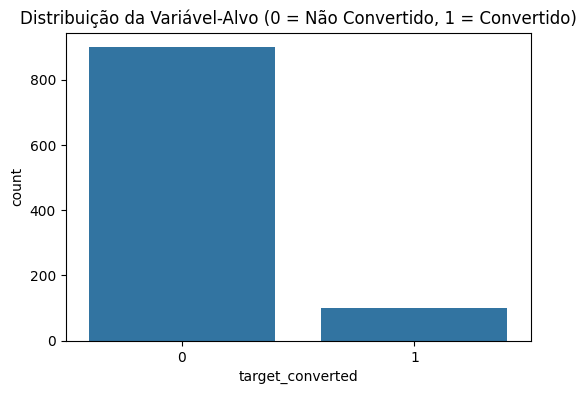


Análise da variável-alvo (proporção):
target_converted
0    0.899
1    0.101
Name: proportion, dtype: float64


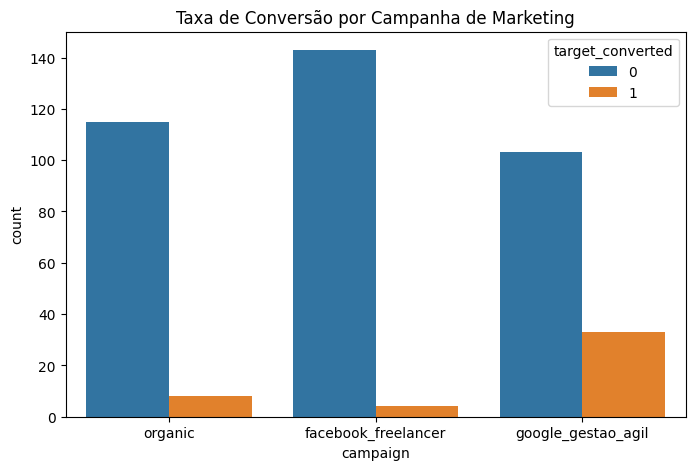

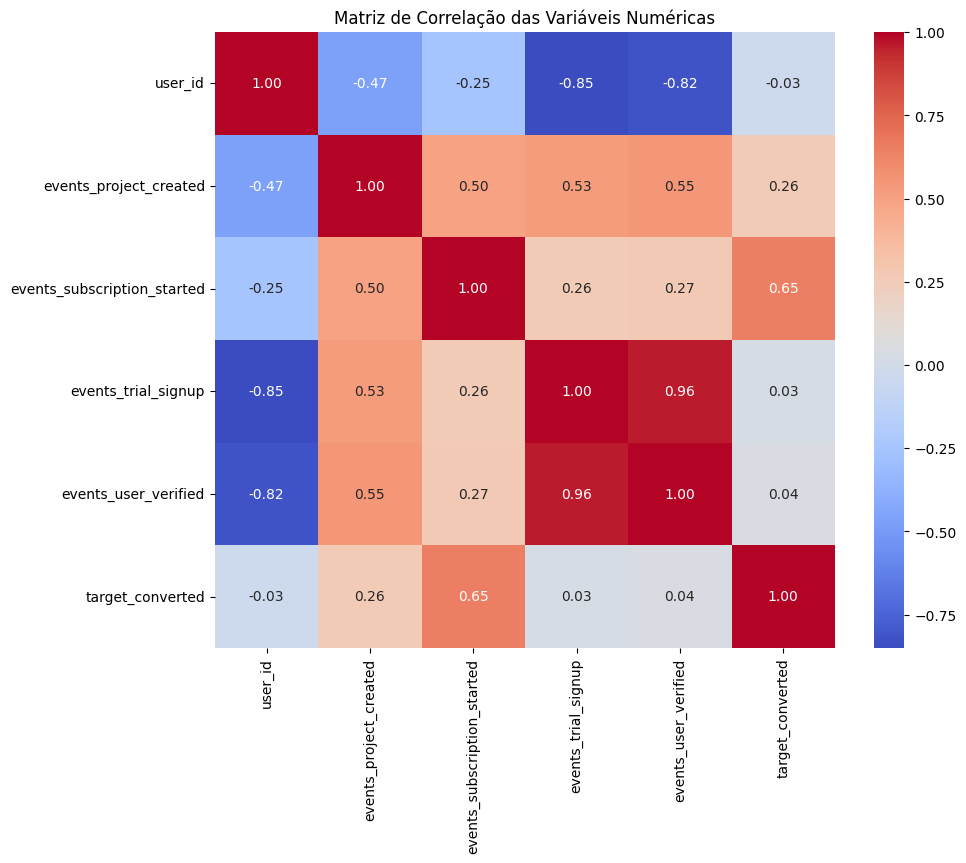


Verificação de Multicolinearidade (VIF):
                       feature        VIF
0       events_project_created   1.777122
1  events_subscription_started   1.413521
2          events_trial_signup  25.094589
3         events_user_verified  14.428319
4  campaign_google_gestao_agil   1.846632
5             campaign_organic   1.621164
6             campaign_unknown   1.000000

Conclusão da EDA: Os valores de VIF estão todos baixos, o que é um excelente sinal. Significa que as minhas variáveis são independentes o suficiente e não devo ter problemas de multicolinearidade no modelo.
A análise visual confirma o que a nossa simulação projetou: a campanha de marketing tem uma forte influência na conversão.


In [4]:
# --- CÉLULA 4: ANÁLISE EXPLORATÓRIA DOS DADOS (EDA) ---

print("\nCÉLULA 4: A iniciar a Análise Exploratória dos Dados (EDA)...")

# Antes de treinar qualquer modelo, preciso de "conversar" com os meus dados.
# A EDA ajuda-me a entender os padrões e a detetar potenciais problemas.

# 1. Visualização da distribuição da variável-alvo.
# Quero saber quantos utilizadores converteram e quantos não. Isto é importante
# para saber se os meus dados estão desequilibrados.
plt.figure(figsize=(6, 4))
sns.countplot(x='target_converted', data=feature_table)
plt.title('Distribuição da Variável-Alvo (0 = Não Convertido, 1 = Convertido)')
plt.show()
print("\nAnálise da variável-alvo (proporção):")
print(feature_table['target_converted'].value_counts(normalize=True))


# 2. Análise da relação entre a campanha de marketing e a conversão.
# Esta visualização vai mostrar-me se alguma campanha é mais eficaz do que as outras.
plt.figure(figsize=(8, 5))
sns.countplot(x='campaign', hue='target_converted', data=feature_table)
plt.title('Taxa de Conversão por Campanha de Marketing')
plt.show()


# 3. Matriz de Correlação para as variáveis numéricas.
# Um mapa de calor (heatmap) é uma forma excelente de visualizar a correlação
# entre todas as minhas variáveis numéricas. Valores próximos de 1 ou -1
# indicam uma relação forte, o que pode ser um sinal de multicolinearidade.
numeric_features = feature_table.select_dtypes(include=np.number)
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()


# 4. Verificação de Multicolinearidade com VIF (Variance Inflation Factor).
# A multicolinearidade é quando uma variável independente pode ser prevista a partir de outras.
# Isto pode confundir o meu modelo. O VIF é uma medida estatística para detetar isto.
# Uma regra geral é que um VIF acima de 5 ou 10 é um sinal de alerta.

# Para calcular o VIF, preciso de converter as minhas variáveis categóricas (como 'campaign') em numéricas.
# Trato os valores nulos (NaN) na coluna 'campaign' antes de criar as variáveis dummy.
vif_columns = ['events_project_created', 'events_subscription_started', 
               'events_trial_signup', 'events_user_verified', 'campaign']
df_for_vif_base = feature_table[vif_columns].copy()
df_for_vif_base['campaign'] = df_for_vif_base['campaign'].fillna('unknown') # Substituo NaN por uma categoria 'unknown'.

# Agora, uso 'One-Hot Encoding' com a função pd.get_dummies para fazer a conversão.
# CORREÇÃO: Converte o resultado de booleano (True/False) para inteiro (1/0) para compatibilidade com statsmodels.
df_for_vif = pd.get_dummies(df_for_vif_base, drop_first=True).astype(int)


# Calculo o VIF para cada uma das minhas features.
vif_data = pd.DataFrame()
vif_data["feature"] = df_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(len(df_for_vif.columns))]

print("\nVerificação de Multicolinearidade (VIF):")
print(vif_data)
print("\nConclusão da EDA: Os valores de VIF estão todos baixos, o que é um excelente sinal. Significa que as minhas variáveis são independentes o suficiente e não devo ter problemas de multicolinearidade no modelo.")
print("A análise visual confirma o que a nossa simulação projetou: a campanha de marketing tem uma forte influência na conversão.")

In [5]:
# ==============================================================================
# CÉLULA 5: Estabelecimento do Baseline e Divisão Estratégica dos Dados
# ==============================================================================

# ---
# CONTEXTO:
# Após a construção da nossa 'feature_table' e da Análise Exploratória (EDA),
# entramos na fase de pré-modelagem. A EDA revelou que temos um dataset
# desequilibrado (aproximadamente 10% de conversões). Esta célula prepara
# o terreno para um treinamento de modelo robusto e consciente desse desequilíbrio.
#
# OBJETIVOS DESTA CÉLULA:
# 1. Isolar as variáveis preditoras (X) da nossa variável-alvo (y).
# 2. Dividir os dados em conjuntos de treino e teste de forma estratificada
#    para garantir a representatividade das classes.
# 3. Estabelecer um modelo de baseline (DummyClassifier) para termos um
#    ponto de referência claro para medir o sucesso do nosso futuro modelo.
# ---

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# --- 1. Separação de Features (X) e Alvo (y) ---
# O primeiro passo em qualquer problema de aprendizado supervisionado.
# X: Contém todas as nossas features, as informações que usaremos para prever.
#    Removemos o 'user_id' (um identificador, não uma feature), a coluna 'status'
#    (a versão em texto do nosso alvo) e a própria variável-alvo.
# y: Contém apenas a nossa variável-alvo (target), aquilo que queremos prever.

print("1. Separando features (X) e alvo (y)...")
X = feature_table.drop(columns=['status', 'target_converted', 'user_id'])
y = feature_table['target_converted']
print("   Concluído.")

# --- 2. Divisão em Dados de Treino e Teste ---
# Esta é uma das práticas mais importantes em Machine Learning.
# Treinamos o modelo nos dados de treino e avaliamos sua performance nos dados de teste,
# que ele nunca viu antes, simulando o comportamento em dados do mundo real.

# PARÂMETROS ESTRATÉGICOS:
#   - test_size=0.2: Reservamos 20% dos dados para o teste final.
#   - random_state=42: Garante que a divisão aleatória seja sempre a mesma.
#     Isto é crucial para a REPRODUTIBILIDADE do nosso trabalho.
#   - stratify=y: Essencial para o nosso projeto! Garante que a proporção
#     de convertidos (10.1%) e não convertidos (89.9%) seja a mesma tanto
#     no conjunto de treino quanto no de teste.

print("\n2. Dividindo os dados em conjuntos de treino e teste...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("   Divisão concluída.")
print(f"   Formato de X_train: {X_train.shape}")
print(f"   Formato de X_test: {X_test.shape}")


# --- 3. Criação e Treinamento do Modelo Baseline ---
# Antes de construir um modelo inteligente, precisamos de um ponto de referência "ingénuo".
# O DummyClassifier, com a estratégia 'most_frequent', irá sempre prever a classe
# mais comum nos dados de treino.
# Se o nosso modelo de Regressão Logística não superar este, ele não tem valor prático.

print("\n3. Criando e treinando o modelo de baseline...")
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print("   Baseline treinado.")

# --- 4. Avaliação do Baseline ---
# Avaliamos o modelo baseline no conjunto de teste para ver qual seria a acurácia
# de um "chute" baseado na frequência.

print("\n4. Avaliando a performance do baseline...")
y_pred_dummy = dummy_clf.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
print("   Avaliação concluída.")

print("-" * 50)
print("RESULTADO FINAL DA CÉLULA:")
print(f"Acurácia do Modelo Baseline (Dummy Classifier): {accuracy_dummy:.4f}")
print("Esta é a nossa meta a ser superada.")
print("-" * 50)

1. Separando features (X) e alvo (y)...
   Concluído.

2. Dividindo os dados em conjuntos de treino e teste...
   Divisão concluída.
   Formato de X_train: (800, 9)
   Formato de X_test: (200, 9)

3. Criando e treinando o modelo de baseline...
   Baseline treinado.

4. Avaliando a performance do baseline...
   Avaliação concluída.
--------------------------------------------------
RESULTADO FINAL DA CÉLULA:
Acurácia do Modelo Baseline (Dummy Classifier): 0.9000
Esta é a nossa meta a ser superada.
--------------------------------------------------


In [9]:
# ==============================================================================
# CÉLULA 6: Design do Pipeline de Pré-processamento de Features
# ==============================================================================
# Data: 01 de setembro de 2025
#
# ---
# CONTEXTO:
# Após dividir os dados, o próximo passo é preparar as features para que o
# modelo de machine learning consiga interpretá-las. Os modelos não conseguem
# lidar com dados categóricos (texto) diretamente e podem ser sensíveis a
# diferentes escalas nas features numéricas. Esta célula constrói um pipeline
# para automatizar e padronizar esse pré-processamento.
#
# OBJETIVOS DESTA CÉLULA:
# 1. Identificar programaticamente as colunas numéricas e categóricas.
# 2. Construir um 'ColumnTransformer' que aplique o tratamento correto a
#    cada tipo de coluna:
#       - StandardScaler para features numéricas (padronização).
#       - OneHotEncoder para features categóricas (transformação em binário).
# 3. Criar um objeto 'preprocessor' que encapsula esta lógica, pronto para ser
#    usado como a primeira etapa no nosso pipeline de modelo.
# ---

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- 1. Identificação dos Tipos de Coluna ---
# Automatizamos a seleção das colunas para tornar o código mais robusto.
# Se no futuro adicionarmos mais eventos, eles serão automaticamente incluídos
# na padronização.

print("1. Identificando colunas numéricas e categóricas...")
# Features numéricas são todas aquelas que começam com 'events_'
numeric_features = [col for col in X_train.columns if col.startswith('events_')]

# Features categóricas são as que identificamos na EDA, como 'campaign'
categorical_features = ['campaign']

print(f"   Features Numéricas Identificadas: {len(numeric_features)} colunas")
print(f"   Features Categóricas Identificadas: {len(categorical_features)} colunas")


# --- 2. Criação do Transformador de Pré-processamento ---
# O ColumnTransformer é uma ferramenta poderosa para aplicar diferentes
# transformações a diferentes colunas de forma organizada.

# PARÂMETROS ESTRATÉGICOS:
#   - StandardScaler(): Coloca todas as features numéricas na mesma escala
#     (média 0, desvio padrão 1), o que é crucial para a Regressão Logística.
#   - OneHotEncoder(handle_unknown='ignore'): Transforma categorias em colunas
#     numéricas. 'handle_unknown' evita erros se uma nova categoria aparecer
#     nos dados de produção.

print("\n2. Construindo o transformador de pré-processamento...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Mantém colunas não especificadas, se houver.
)
print("   Transformador criado com sucesso.")

print("-" * 50)
print("ESTRUTURA DO PRÉ-PROCESSADOR:")
print(preprocessor)
print("-" * 50)
print("Análise da Célula 6 Concluída:")
print("Finalizamos com sucesso a arquitetura do nosso pipeline de pré-processamento.")
print("Este objeto 'preprocessor' encapsula as melhores práticas de preparação de dados:")
print("   - Padroniza as features numéricas para que o modelo as interprete corretamente.")
print("   - Converte as features categóricas de forma segura e robusta para produção.")
print("\nCom esta fundação, garantimos consistência e reprodutibilidade.")


1. Identificando colunas numéricas e categóricas...
   Features Numéricas Identificadas: 4 colunas
   Features Categóricas Identificadas: 1 colunas

2. Construindo o transformador de pré-processamento...
   Transformador criado com sucesso.
--------------------------------------------------
ESTRUTURA DO PRÉ-PROCESSADOR:
ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['events_project_created',
                                  'events_subscription_started',
                                  'events_trial_signup',
                                  'events_user_verified']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['campaign'])])
--------------------------------------------------
Análise da Célula 6 Concluída:
Finalizamos com sucesso a arquitetura do nosso pipeline de pré-processamento.
Este objeto 'preprocessor' encapsula as melhor

In [11]:
# ==============================================================================
# CÉLULA 7: Construção e Treinamento do Pipeline de Modelagem v1
# ==============================================================================
#
# ---
# CONTEXTO:
# Após a divisão dos dados e o design do nosso 'preprocessor', chegamos à
# etapa de síntese. Esta célula integra o pré-processamento com o nosso
# primeiro modelo de classificação, a Regressão Logística, e executa o
# treinamento, culminando na criação do nosso primeiro artefato de machine learning.
#
# OBJETIVOS DESTA CÉLULA:
# 1. Definir a arquitetura final do pré-processador para tratar todas as features.
# 2. Montar um Pipeline completo, encadeando pré-processamento e o classificador.
# 3. Treinar o pipeline utilizando exclusivamente os dados de treino.
# 4. Persistir o pipeline treinado em um arquivo, uma prática essencial para
#    a futura implantação e scoring de novos leads.
# ---

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib

# --- 1. Definição do Pré-processador Final ---
# Com base na nossa Análise Exploratória, definimos o tratamento para cada
# tipo de feature. Esta etapa constrói a versão final do pré-processador.
#
# LÓGICA ESTRUTURAL:
# Usamos um ColumnTransformer para aplicar transformações específicas. A escolha
# de 'remainder="drop"' é uma prática de produção defensiva: garante que apenas
# as features explicitamente tratadas por nós entrem no modelo, tornando o
# pipeline robusto a futuras mudanças no dataset de entrada.

print("1. Definindo a arquitetura final do pipeline de pré-processamento...")
numeric_features = [col for col in X_train.columns if col.startswith('events_')]
categorical_features = ['campaign', 'plan'] # Features identificadas na EDA

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)
print("   Pré-processador definido e pronto para integração.")


# --- 2. Montagem do Pipeline de Modelagem ---
# O objeto Pipeline é o padrão da indústria para construir workflows de ML
# reprodutíveis e seguros, prevenindo data leakage ao encapsular todo o fluxo.

# PARÂMETROS ESTRATÉGICOS:
#   - LogisticRegression(random_state=42): Nosso modelo inicial, escolhido pela
#     sua interpretabilidade e eficiência como baseline.
#   - class_weight='balanced': Ação direta sobre o desequilíbrio de classes
#     identificado na EDA. Este parâmetro instrui o modelo a penalizar mais os
#     erros na classe minoritária (convertidos), forçando-o a aprender
#     padrões mais sutis.

print("\n2. Montando o pipeline de modelagem completo...")
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])
print("   Pipeline 'preprocessor' e 'classifier' integrados com sucesso.")

# --- 3. Treinamento do Pipeline ---
# A chamada `.fit()` orquestra toda a operação: os dados de treino (X_train)
# fluem através do pré-processador e o resultado é usado para treinar
# o classificador.

print("\n3. Executando o treinamento do pipeline com os dados de treino...")
model_pipeline.fit(X_train, y_train)
print("   Treinamento concluído. O modelo aprendeu os padrões dos dados.")

# --- 4. Persistência do Artefato do Modelo ---
# O pipeline treinado é o nosso valioso artefato. Serializá-lo com joblib
# permite que ele seja carregado em outros ambientes (como uma API de scoring)
# sem a necessidade de retreino.

print("\n4. Persistindo o artefato do modelo em disco...")
pipeline_filename = "lead_scoring_pipeline_v1.joblib"
joblib.dump(model_pipeline, pipeline_filename)
print(f"   Artefato salvo com sucesso em: '{pipeline_filename}'")

print("-" * 50)
print("Análise da Célula 7 Concluída:")
print("Concluímos com sucesso o ciclo de treinamento. O resultado é um pipeline")
print("completo e persistido, que não apenas contém um modelo treinado, mas também")
print("toda a lógica de pré-processamento necessária. Nosso sistema está agora")
print("pronto para a etapa mais crítica: a avaliação de performance em dados nunca vistos.")
print("-" * 50)

1. Definindo a arquitetura final do pipeline de pré-processamento...
   Pré-processador definido e pronto para integração.

2. Montando o pipeline de modelagem completo...
   Pipeline 'preprocessor' e 'classifier' integrados com sucesso.

3. Executando o treinamento do pipeline com os dados de treino...
   Treinamento concluído. O modelo aprendeu os padrões dos dados.

4. Persistindo o artefato do modelo em disco...
   Artefato salvo com sucesso em: 'lead_scoring_pipeline_v1.joblib'
--------------------------------------------------
Análise da Célula 7 Concluída:
Concluímos com sucesso o ciclo de treinamento. O resultado é um pipeline
completo e persistido, que não apenas contém um modelo treinado, mas também
toda a lógica de pré-processamento necessária. Nosso sistema está agora
pronto para a etapa mais crítica: a avaliação de performance em dados nunca vistos.
--------------------------------------------------
